In [1]:
# Source code used to predict the heat classification from the file 6_25 Heat Index Sample.xlxs
# Jalaluddin Qureshi, George Brown College, AY 2019-21, Summer 2020.

# These command are being run on the Jupyter Notebook environment, which requires download and installation
# of Anaconda (https://docs.anaconda.com/anaconda/install/). Once installed, a short introduction on using 
# Jupyter notebook can be found online such as this one, https://www.youtube.com/watch?v=HW29067qVWk.

# In this cell we are importing the relevant training models which are needed to train our predictive model.
# While running this cell for the first time there is a possibiity that some of the module may require
# installation, the installation command is of this form $ pip install -U module_name (I tend google 
# the full actual installation command). The installation command needs to be run on anaconda command promopt.
# Anaconda command window comes with Anaconda installation, it does not requires any separate installation.
#

import pandas as pd
from sklearn.model_selection import train_test_split
from dmba import classificationSummary
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier 

from sklearn import svm #Support Vector Machine
from sklearn.neural_network import MLPClassifier # Neural Net
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn.model_selection import GridSearchCV #Needed for Decision Tree
from sklearn.tree import DecisionTreeClassifier #Needed for Decision Tree

no display found. Using non-interactive Agg backend


In [2]:
# It is assumed that the data file should be in the same folder in which the jupyter notebook has been opened-saved. 
# If it is not in the same folder, then that would also require providing the full path.

# The data columns which are of interest are listed in the predictor variable. Other columns may be added
# or removed. The s.strip() replaces any empty space with an underscore, e.g. "Total Value" becomes "Total_Value".
# So the name of the variables which are added in predictor must follow this convention.
# I had also shortened some variable name manually on Excel for simplicity, 
# e.g. "Est # Historic Customers for product family (2015-Present)" is relabbeled as "historic", and a new variable
# "Time_EOL" is generated as follow: Time_EOL=2020-EOL, to determine the number of years since the compent became
# obselete.

# It is assumed that for the "predictor variable" there should be no missing/ empty cells, and no "out of bound" values,
# e.g. all the values in "Price" must be numeric, if there is any non-numeric value then error will be generated later.

# The "outcome" variable is what we want to predict - Cold and Warm. In my analysis I relabelled all "Hot" as "Warm".
# This was done as designing predictive model gets complex when the number of distinct output values are more than two.
# Another challenges of working with records with "Hot" index for the given data is that there were only three records
# with "Hot" as its Heat index - when the number of records with a given Heat index is very small in the historical 
# train data, then it does not lead to good prediction for the unknown data.

# The data (specially numeric) should also be formatted on Excel, e.g. ensure that "Price" is a numeric quantity by 
# right clicking that column, click "Format Cell", select. And remove the $ sign and any comma.

# Once this has been done, click on "save as" in excel, and then save the file as a csv file in the same folder.

#flip_df = pd.read_csv('heat.csv')
flip_df = pd.read_csv('Heat Exercise 5.csv')
flip_df.columns = [s.strip().replace(' ', '_') for s in flip_df.columns]
predictors = ['Family', 'Qty', 'Price_(Ea.)', 'EOL_time', 'Historic_Customers'] # 'Price_(Ea.)', 'EOL_time', 'Historic_Customers', 
outcome = 'Heat_Encode'
#outcome = 'Heat'

X1=flip_df[predictors]
y1=flip_df[outcome]


In [3]:
# In this cell, the data which has been fetched from the csv file (xlsx -> csv) is displayed for visual inspection.
# Only the first 5 rows are display by default, if you would like to see larger number of rows, enter the value 
# inside the paranthesis e.g. flip_df(7)

flip_df.head()

,Family,Historic_Customers,EOL,EOL_time,Finished_Goods_Inventory,Description,Qty,Price_(Ea.),Total_Line_Value,Est_Die,Comments,Heat,Heat_Encode,Flip_Stock,Sales_History,Total_Quotes,Quoted_Amount,Authorized_Availability,Authorized_Price
0,DSP56311,85,2018,2,DSP56311VF150R2,NaN,1967,34.76,"$68,372.92",15250,All PN's listed here,Cold,0,NaN,NaN,3.0,"1,759",NaN,NaN
1,DSP56311,85,2018,2,DSP56311VL150,NaN,538,34.76,"$18,700.88",NaN,NaN,Warm,1,NaN,NaN,2.0,"5,450",NaN,NaN
2,C1K,47,2017,3,M83159G13,NaN,99,13.41,"$1,327.59",NaN,NaN,Cold,0,NaN,NaN,NaN,NaN,NaN,NaN
3,C1K,47,2017,3,M83160G13,NaN,314,11.95,"$3,752.30",NaN,NaN,Cold,0,NaN,NaN,NaN,NaN,84,$14.80
4,C1K,47,2017,3,M83240G13,NaN,281,13.41,"$3,768.21",NaN,NaN,Cold,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# The first line encodes the categorical data. The second line splits the data into training and validation data.

# In this cell, we are only reading "historical data" with known actual value of the heat index, and the records
# with unknown heat index value (labelled as X_new). The number of cell with known heat index value is listed within 
# the square brackets [0:72]. When the number of records changes, this value should also change.

# The records with unknown heat index, and known heat index should be in the same csv data file. 
# Note here that Python labels the first record as zero, whereas in Excel the first record is labelled as one. In Excel,
# the first row is used to label to columns.

X1 = pd.get_dummies(X1, prefix_sep='_', drop_first=False)

X = X1.loc[0:72]
y = y1.loc[0:72]

X_new = X1.loc[73:73]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [5]:
# In this I can visually inspect the record with unknown het index. Categorical data has been encoded.

X1

,Qty,Price_(Ea.),EOL_time,Historic_Customers,Family_C1K,Family_DSP56311,Family_Galaxy / MSC8122,Family_Goldfinger / MPC755,Family_MPC823 / T823,Family_MPC8241-D,Family_MPC8540 / PQ37,Family_MPC8541 / PQ37L,Family_MPC8555 / PQ37L,Family_MPC8560 / PQ37,Family_MPC857,Family_MPC862,Family_P1017,Family_P1023
0,1967,34.76,2,85,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,538,34.76,2,85,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,99,13.41,3,47,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,314,11.95,3,47,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,281,13.41,3,47,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,5637,117.20,5,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0
69,978,36.72,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0
70,167,41.06,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0
71,417,40.82,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,1


********************
<b><u>Classifiers</u></b><br>
Now that I have fetched the clean data, I can now start training-testing our data with various classification algorithm.
I am using the ensemble learning approach to make prediction - Essentially this approach makes use of "Majority Voting"
approach to make decision, i.e. I train more than one classifier, and then when all the classifiers have been trained,
then for the unknown data these classifiers "vote" whether the outcome will be "Cold" or "Warm". Decision is then made in favour of heat index value which gets the highest number of votes.

However the performance of the "Majority Voting" approach is dependent on choosing suitable classifiers which can participate
in the voting decision. Theoretically, a classifier which achieves an accuracy of >50% is selected, however in practise the
threshold value is user-defined.
********************

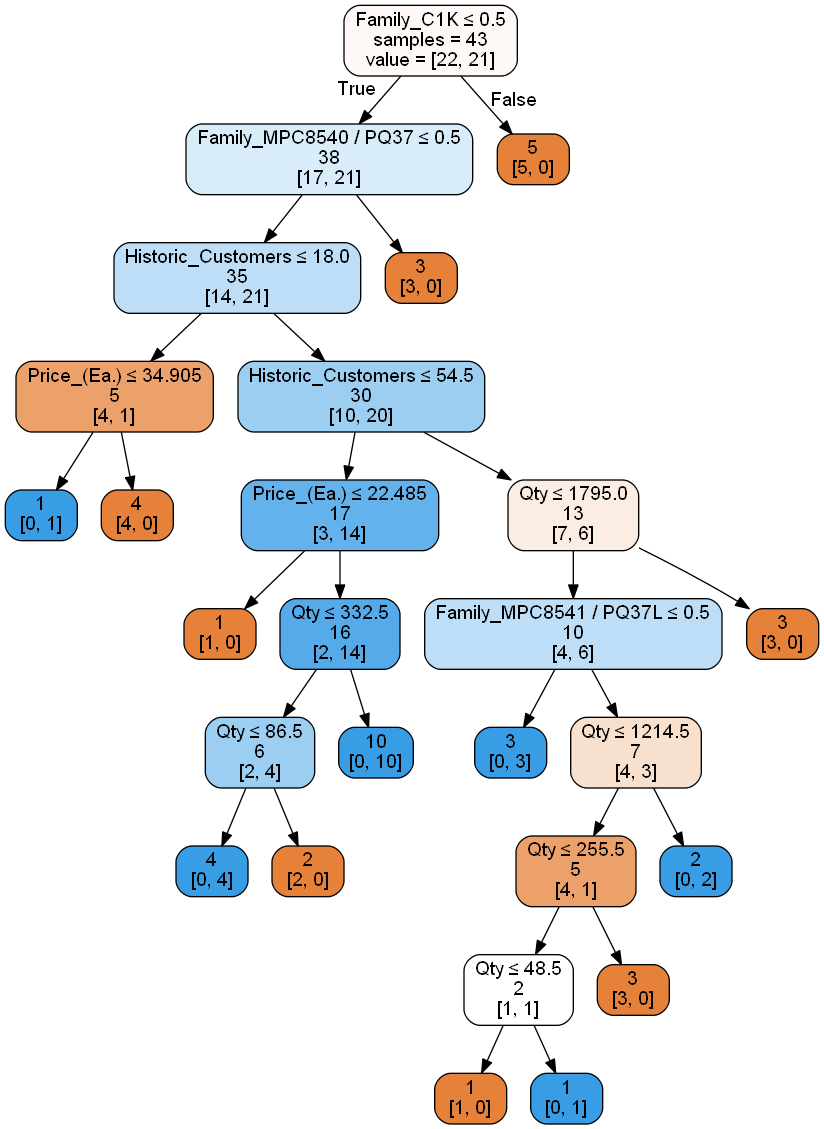

In [9]:
from dmba import plotDecisionTree
fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns)

In [10]:
# This is our first classifier (known as Decision Tree). No changes need to made here.

# Start with an initial guess for parameters
param_grid = {
'max_depth': [10, 20, 30, 40],
'min_samples_split': [20, 40, 60, 80, 100],
'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
}

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1) # n_jobs=-1 will utilize all available CPUs
gridSearch.fit(train_X, train_y)

#print('Initial score: ', gridSearch.best_score_)
#print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
'max_depth': list(range(2, 16)), # 14 values
'min_samples_split': list(range(10, 22)), # 11 values
'min_impurity_decrease': [0.0009, 0.001, 0.0011], # 3 values
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5,
n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)
bestClassTree = gridSearch.best_estimator_

Improved score:  0.586111111111111
Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.0009, 'min_samples_split': 10}


In [11]:
# This cell will output the accuracy of the Decision Tree. As the accuracy is 73% ( more than 50%) for the validation 
# data, I can theoretically admit this classifier in the Majority Voting later.
classificationSummary(valid_y, gridSearch.predict(valid_X), class_names=['Cold', 'Warm'])

Confusion Matrix (Accuracy 0.7333)

       Prediction
Actual Cold Warm
  Cold    5    7
  Warm    1   17


In [12]:
# This cell trains a second classifier (Random Forest) and outputs the accuracy. No changes need to be made in this cell.

rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)
classificationSummary(valid_y, rf.predict(valid_X), class_names=['Cold', 'Warm'])

Confusion Matrix (Accuracy 0.7667)

       Prediction
Actual Cold Warm
  Cold    8    4
  Warm    3   15


In [13]:
# This cell trains a third classifier (Gradient Boosting) and outputs the accuracy. No changes need to be made in this cell.

boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X), class_names=['Cold', 'Warm'])

Confusion Matrix (Accuracy 0.7667)

       Prediction
Actual Cold Warm
  Cold    8    4
  Warm    3   15


In [14]:
# This cell trains a fourth classifier (Neural Net) and outputs the accuracy. No changes need to be made in this cell.
# The cell may output a message such "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT." However this should not be a cause
# of any concern. No changes need to be made here.

classes = sorted(y.unique())
clf = MLPClassifier(hidden_layer_sizes=(500), activation='logistic', solver='lbfgs', random_state=1, max_iter=20000)
clf.fit(train_X, train_y)
classificationSummary(valid_y, clf.predict(valid_X), class_names=classes)

Confusion Matrix (Accuracy 0.6333)

       Prediction
Actual  0  1
     0  8  4
     1  7 11


In [15]:
# This cell trains a fifth classifier (Neural Net with different parameters) and outputs the accuracy. 
# No changes need to be made in this cell.

clf2 = MLPClassifier(hidden_layer_sizes=(200), activation='tanh', solver='lbfgs', random_state=1, max_iter=20000)
clf2.fit(train_X, train_y)
#clf2.predict(X)
classificationSummary(valid_y, clf2.predict(valid_X), class_names=classes)

Confusion Matrix (Accuracy 0.7333)

       Prediction
Actual  0  1
     0  8  4
     1  4 14


In [16]:
# This cell trains a sixth classifier (Logistic Regression) and outputs the accuracy. 
# No changes need to be made in this cell.

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)
classificationSummary(valid_y, logit_reg.predict(valid_X), class_names=['Cold', 'Warm'])

Confusion Matrix (Accuracy 0.6333)

       Prediction
Actual Cold Warm
  Cold    7    5
  Warm    6   12


In [19]:
# This cell trains a seventh classifier (SVM with polynomial of degree 5) and outputs the accuracy. 
# No changes need to be made in this cell.

h1 = svm.SVC(kernel='poly', degree=5, gamma=0.001, C=1.0) # Polynomial degree 5 SVC #probability=True
h1.fit(train_X, train_y)
classificationSummary(valid_y, h1.predict(valid_X), class_names=['Cold', 'Warm'])

Confusion Matrix (Accuracy 0.7333)

       Prediction
Actual Cold Warm
  Cold    6    6
  Warm    2   16


In [17]:
# This cell trains a eighth classifier (SVM with polynomial of degree 2) and outputs the accuracy. 
# No changes need to be made in this cell.

h2 = svm.SVC(kernel='poly', degree=2, gamma=0.001, C=1.0) # probability=True
h2.fit(train_X, train_y)
classificationSummary(valid_y, h2.predict(valid_X), class_names=['Cold', 'Warm'])

Confusion Matrix (Accuracy 0.6667)

       Prediction
Actual Cold Warm
  Cold    7    5
  Warm    5   13


In [18]:
# This cell trains an ninth classifier (KNN with two classes) and outputs the accuracy. 
# No changes need to be made in this cell.

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(2)
knn.fit(train_X, train_y)
classificationSummary(valid_y, knn.predict(valid_X), class_names=['Cold', 'Warm'])

Confusion Matrix (Accuracy 0.6667)

       Prediction
Actual Cold Warm
  Cold    9    3
  Warm    7   11


***************
<u><b>Classifiers Selection</b></u><br>
Now that I have trained various classifiers, I will now select those classifers with accuracy >50%, and then run my final
evaluation, and use it to predict the unknown data values. For the voting decision not to result in a tie, an odd number
of classifier should be selected.
<br>
<br>
Comment out those classifier using # which are not needed because of their relatively poor accuracy performance. I am selecting the top 5 classifiers for my model.
***************

In [20]:
# MAJORITY VOTING
# Now that various classifiers have been trained use majority voting here.
# This cell can take FEW minutes to execute depending on the processor of the computer system used.

eclf1 = VotingClassifier(estimators=[
    
                                     ('GS', gridSearch),
                                     ('RF', rf),  
                                     ('Boost', boost),
                                   #  ('NN1', clf), 
                                     ('NN2', clf2),
                                    # ('LOG', logit_reg),
                                     ('SVM1', h1),
                                    # ('SVM2', h2),
                                    # ('KNN', knn)
    
                                    ], voting='hard')

eclf1 = eclf1.fit(train_X, train_y)

In [21]:
print('Accuracy of validation data: ')
classificationSummary(valid_y, eclf1.predict(valid_X), class_names=['Cold', 'Warm'])

print('Accuracy of full data: ')
classificationSummary(y, eclf1.predict(X), class_names=['Cold', 'Warm'])

Accuracy of validation data: 
Confusion Matrix (Accuracy 0.8000)

       Prediction
Actual Cold Warm
  Cold    8    4
  Warm    2   16
Accuracy of full data: 
Confusion Matrix (Accuracy 0.9178)

       Prediction
Actual Cold Warm
  Cold   30    4
  Warm    2   37


In [ ]:
# In this cell I generate "belief probability" of the decision. The choice of classifier which I select is based on
# their accuracy, and may not necessarily reflect classifiers selected during the MAJORITY VOTING cell.
# In the last line, only those prob values should be included in the average_proba calculatin which were not 
# commented. The number with which it is divided should reflect the number of variables which are being added up.

# These steps are needed if the analyst wishes to manually validate heat index decision for records with relatively lower
# probabilities.

#gridSearch_proba = gridSearch.predict_proba(X)
#rf_proba = rf.predict_proba(X)
#boost_proba = boost.predict_proba(X)
#clf_proba = clf.predict_proba(X)
#clf_proba2 = clf2.predict_proba(X_new)
#logit_reg_proba = logit_reg.predict_proba(X_new)
#h1_proba = h1.predict_proba(X_new) # can not be uncommented, as there is no probability associated with SVM !!!
#h2_proba = h2.predict_proba(X_new) # can not be uncommented, as there is no probability associated with SVM !!!
#knn_proba = knn.predict_proba(X_new)

#average_proba=(gridSearch_proba+rf_proba+boost_proba+clf_proba)/4

In [ ]:
#final_predict=eclf1.predict(X)

#final_result = pd.DataFrame({'actual': y,
#'cold prob.': [p[0] for p in average_proba],
#'warm prob.': [p[1] for p in average_proba],
#'predicted': final_predict })

#print(final_result)

In [ ]:
# The result (cold/ warm prob. and predicted) produced in the previous cell will now be imported to the file "result.csv". 
# The analyst can aggregate this result with the result in the original fule "heat.csv" to perform any further function
# as required.

#final_result.to_csv(r'C:\Users\jalaluddin\Desktop\GBC B412\Data Project Capstone BUS 4045\Assignments\imbalance\result.csv', index = False)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [ ]:
# Classifiers which we choose for majority voting
# We plot the AUC of the those classifiers which have been selected for the Majority Voting. 

y_pred_proba_gridSearch = gridSearch.predict_proba(valid_X)[::,1]
y_pred_proba_rf = rf.predict_proba(valid_X)[::,1]
y_pred_proba_boost = boost.predict_proba(valid_X)[::,1]
y_pred_proba_clf2 = clf2.predict_proba(valid_X)[::,1]
y_pred_proba_knn = knn.predict_proba(valid_X)[::,1]


In [ ]:

fpr1, tpr1, _ = metrics.roc_curve(valid_y,  y_pred_proba_rf)
fpr2, tpr2, _ = metrics.roc_curve(valid_y,  y_pred_proba_boost)
fpr3, tpr3, _ = metrics.roc_curve(valid_y,  y_pred_proba_gridSearch)
fpr4, tpr4, _ = metrics.roc_curve(valid_y,  y_pred_proba_clf2)
fpr5, tpr5, _ = metrics.roc_curve(valid_y,  y_pred_proba_knn)

In [ ]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
auc1 = metrics.roc_auc_score(valid_y, y_pred_proba_rf)
auc2 = metrics.roc_auc_score(valid_y, y_pred_proba_boost)
auc3 = metrics.roc_auc_score(valid_y, y_pred_proba_gridSearch)
auc4 = metrics.roc_auc_score(valid_y, y_pred_proba_clf2)
auc5 = metrics.roc_auc_score(valid_y, y_pred_proba_knn)


plt.figure()

plt.plot(fpr1,tpr1, lw=2, label='Random Forest ROC curve (area = %0.2f)' % auc1) #color='navy', 
plt.plot(fpr2,tpr2, lw=2, label='Gradient Boost ROC curve (area = %0.2f)' % auc2) #color='navy', 
plt.plot(fpr3,tpr3, lw=2, label='Decision Tree ROC curve (area = %0.2f)' % auc3) #color='navy', 
plt.plot(fpr4,tpr4, lw=2, label='Neural Network ROC curve (area = %0.2f)' % auc4) #color='navy', 
plt.plot(fpr5,tpr5, lw=2, label='KNN ROC curve (area = %0.2f)' % auc5) #color='navy', 

plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.savefig("classifiers1.png")

In [ ]:
# MAJORITY VOTING
# Soft voting so that a probability estimate can be obtained fr AUC plotting.

eclf2 = VotingClassifier(estimators=[
    
                                     ('GS', gridSearch),
                                     ('RF', rf),  
                                     ('Boost', boost),
                                    # ('NN1', clf), 
                                     ('NN2', clf2),
                                    # ('LOG', logit_reg),
                                    # ('SVM1', h1),
                                    # ('SVM2', h2),
                                     ('KNN', knn)
    
                                    ], voting='soft')

eclf2 = eclf2.fit(train_X, train_y)

print('Accuracy of validation data: ')
classificationSummary(valid_y, eclf2.predict(valid_X), class_names=['Cold', 'Warm'])

print('Accuracy of full data: ')
classificationSummary(y, eclf2.predict(X), class_names=['Cold', 'Warm'])

In [ ]:
#Plotting the AUC for the Soft Voting AUC graph.

y_pred_proba_eclf2 = eclf2.predict_proba(valid_X)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(valid_y,  y_pred_proba_eclf2)
auc6 = metrics.roc_auc_score(valid_y, y_pred_proba_eclf2)
plt.figure()
plt.plot(fpr6,tpr6, lw=2, label='Majority Voting ROC curve (area = %0.2f)' % auc6) #color='navy', 
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.savefig("majority_class.png")